In [1]:
import imufusion
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.spatial.transform import Rotation as R

In [2]:
my_data = np.genfromtxt('D:/_xueXi/keCheng/2022S/PHYSCS15CExp/codeFiles/accelGyroLog0529test0.csv',delimiter=',')

In [3]:
#codeFiles/accelGyroLogtest2
#testData0525/accelGyroLog5033170

In [3]:
timestamp = [0]
for index, t_interval in enumerate(my_data[:, 0]):
    timestamp.append(timestamp[index]+t_interval)
timestamp.pop(-1)

20.901519404999906

In [4]:
t_interval_list = my_data[:, 0]
gyroscopeR = my_data[:, 4:7]
accelerometer = my_data[:, 1:4]

In [5]:
sample_rate = (timestamp[len(timestamp)-1]-timestamp[0])/len(timestamp)

In [6]:
sample_rate

0.0020899464162999907

In [7]:
gyroscope = np.degrees(gyroscopeR)

In [8]:
# indexGyroCalib = next(x for x, val in enumerate(timestamp) if val>3)
# calibration_gyro = []
gyroRaw = gyroscope #np.empty(gyroscopeR.shape)
count = 0
for indAxis in [0,1,2]:
    #noise = sum(gyroscopeR[:indexGyroCalib,indAxis])/indexGyroCalib
    #gyroCalib[:,indAxis] = gyroscopeR[:,indAxis] - noise
    for i in range(0,len(gyroscope[:,0])):
        if abs(gyroscope[i,indAxis])<0.0:
            count+=1
            gyroscope[i,indAxis]=0

In [9]:
#gyroscopeR[:,1][0]
count

0

In [10]:
ahrs = imufusion.Ahrs()
eulerR = np.empty((len(timestamp), 3))

for index in range(len(timestamp)):
    ahrs.update_no_magnetometer(gyroscope[index], accelerometer[index], sample_rate)  # 100 Hz sample rate
    eulerR[index] = ahrs.quaternion.to_euler()

In [11]:
euler = eulerR[500:]

In [12]:
r = R.from_euler('xyz', euler, degrees=True)
absAccel = r.apply(accelerometer[500:])
timestamp=timestamp[500:]

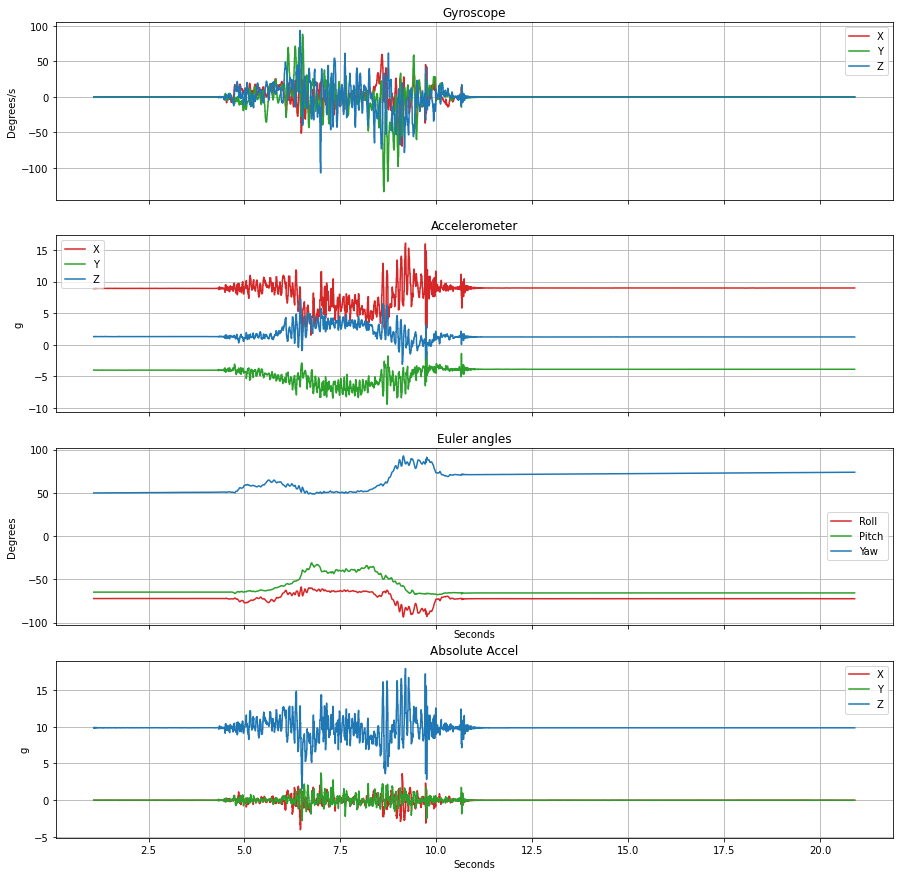

In [20]:
_, axes = plt.subplots(nrows=4, sharex=True, figsize=(15,15))

axes[0].plot(timestamp, gyroscope[500:, 0], "tab:red", label="X")
axes[0].plot(timestamp, gyroscope[500:, 1], "tab:green", label="Y")
axes[0].plot(timestamp, gyroscope[500:, 2], "tab:blue", label="Z")
axes[0].set_title("Gyroscope")
axes[0].set_ylabel("Degrees/s")
axes[0].grid()
axes[0].legend()

#axes[0].set_xlim(0,5)

axes[1].plot(timestamp, accelerometer[500:, 0], "tab:red", label="X")
axes[1].plot(timestamp, accelerometer[500:, 1], "tab:green", label="Y")
axes[1].plot(timestamp, accelerometer[500:, 2], "tab:blue", label="Z")
axes[1].set_title("Accelerometer")
axes[1].set_ylabel("g")
axes[1].grid()
axes[1].legend()

axes[2].plot(timestamp, euler[:, 0], "tab:red", label="Roll")
axes[2].plot(timestamp, euler[:, 1], "tab:green", label="Pitch")
axes[2].plot(timestamp, euler[:, 2], "tab:blue", label="Yaw")
axes[2].set_title("Euler angles")
axes[2].set_xlabel("Seconds")
axes[2].set_ylabel("Degrees")
axes[2].grid()
axes[2].legend()

axes[3].plot(timestamp, absAccel[:, 0], "tab:red", label="X")
axes[3].plot(timestamp, absAccel[:, 1], "tab:green", label="Y")
axes[3].plot(timestamp, absAccel[:, 2], "tab:blue", label="Z")
axes[3].set_title("Absolute Accel")
axes[3].set_xlabel("Seconds")
axes[3].set_ylabel("g")
axes[3].grid()
axes[3].legend()

In [14]:
next(x for x, val in enumerate(timestamp) if val>4)

1403

In [15]:
index = next(x for x, val in enumerate(timestamp) if val>4)
calibration_g = []
accelCalib = np.empty(absAccel.shape)
for indAxis in [0,1,2]:
    noise = sum(absAccel[:index,indAxis])/index
    accelCalib[:,indAxis] = absAccel[:,indAxis] - noise

In [16]:
accelCalib[:,0]

array([ 0.00633278,  0.00621676, -0.0058734 , ..., -0.00198396,
       -0.00195219,  0.00309673])

In [17]:
totNum = len(t_interval_list[500:])
velo_list = np.empty(accelCalib.shape)
posi_list = np.empty(accelCalib.shape)
velo_list[0] = [0,0,0]
posi_list[0] = [0,0,0]

for indAxis in [0,1,2]:
    i=0
    while i<totNum:
        if i > 0:
            if abs(accelCalib[i,indAxis])<0.04:
                velo_list[i,indAxis] = velo_list[i-1,indAxis]
            else:
                velo_list[i,indAxis] = velo_list[i-1,indAxis] + accelCalib[i,indAxis] * t_interval_list[500+i]
            posi_list[i,indAxis]=(posi_list[i-1,indAxis] + velo_list[i,indAxis] * t_interval_list[500+i])
        i+=1

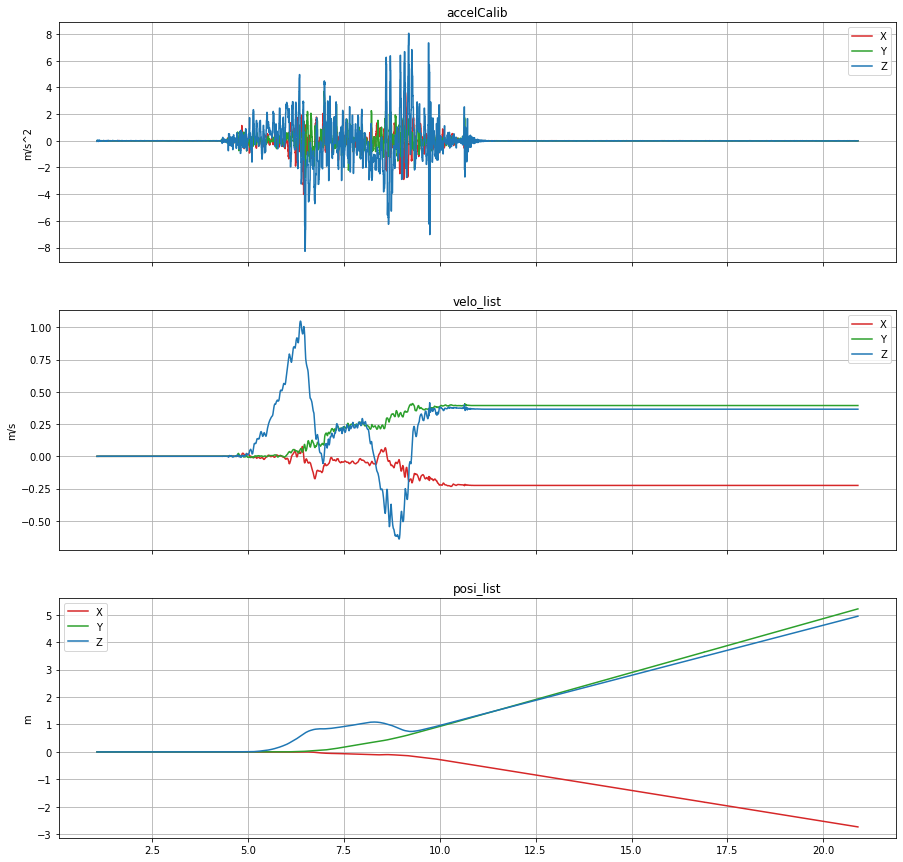

In [19]:
_, axesR = plt.subplots(nrows=3, sharex=True, figsize=(15,15))

axesR[0].plot(timestamp, accelCalib[:, 0], "tab:red", label="X")
axesR[0].plot(timestamp, accelCalib[:, 1], "tab:green", label="Y")
axesR[0].plot(timestamp, accelCalib[:, 2], "tab:blue", label="Z")
axesR[0].set_title("accelCalib")
axesR[0].set_ylabel("m/s^2")
axesR[0].grid()
#axesR[0].set_xlim(0,5)
axesR[0].legend()

axesR[1].plot(timestamp,velo_list[:, 0], "tab:red", label="X")
axesR[1].plot(timestamp, velo_list[:, 1], "tab:green", label="Y")
axesR[1].plot(timestamp, velo_list[:, 2], "tab:blue", label="Z")
axesR[1].set_title("velo_list")
axesR[1].set_ylabel("m/s")
axesR[1].grid()
#axesR[1].set_xlim(0,60)
axesR[1].legend()

axesR[2].plot(timestamp,posi_list[:, 0], "tab:red", label="X")
axesR[2].plot(timestamp,posi_list[:, 1], "tab:green", label="Y")
axesR[2].plot(timestamp,posi_list[:, 2], "tab:blue", label="Z")
axesR[2].set_title("posi_list")
axesR[2].set_ylabel("m")
axesR[2].grid()
#axesR[2].set_xlim(0,60)
#axesR[2].set_ylim(-10,40)
axesR[2].legend()

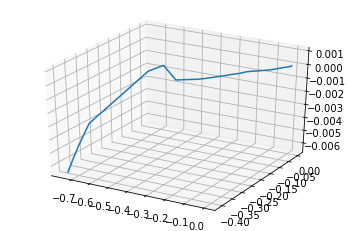

In [20]:
fig = plt.figure()

# syntax for 3-D projection
ax = plt.axes(projection ='3d')

# defining all 3 axes

x = posi_list[:, 0]
y = posi_list[:, 1]
z = posi_list[:, 2]
# plotting
ax.plot3D(x, y, z)
plt.show()


In [21]:
a_list = [[1,2,3],[],[]]

for indAxis in [0,1,2]:
    i=0
    while i<totNum-1:
        velo_list[i,indAxis]=(velo_list[i,indAxis] + a_list[i,indAxis] * t_interval_list[i])
        posi_list[i,indAxis]=(posi_list[i,indAxis] + velo_list[i,indAxis] * t_interval_list[i])
        i+=1

TypeError: list indices must be integers or slices, not tuple